In [1]:
! pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.3 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import optim
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torcheval.metrics.functional import peak_signal_noise_ratio
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(66)
from PIL import Image

In [3]:
# import zipfile
# import os

# zip_file_path = 'Khoa_LHR_image.zip'
# extractfolder = './data'

# os.makedirs(extractfolder, exist_ok=True)

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extractfolder)

# print(f"Tệp đã được giải nén vào thư mục: {extractfolder}")

In [4]:
import os

def extract_filepath(folder_root, type):
    lst_paths = []
    folder_dir = os.path.join(folder_root, type)
    for path in os.listdir(folder_dir):
        lst_paths.append(os.path.join(folder_dir, path))
    return lst_paths

train_paths = extract_filepath('/kaggle/input/khoa-lhr-image/Khoa_LHR_image', 'train')
val_paths = extract_filepath('/kaggle/input/khoa-lhr-image/Khoa_LHR_image', 'val')

In [5]:
img = Image.open(train_paths[0]).convert('RGB')
np.array(img).shape

(256, 256, 3)

In [6]:
torch.rand([])

tensor(0.4976)

In [7]:
batch_size = 8
low_img_height = 64
low_img_width = 64

class ImageDataset(Dataset):
    def __init__(self, paths ,low_img_height, low_img_width, is_train):
        super().__init__()
        self.low_img_height = low_img_height
        self.low_img_width = low_img_width
        self.paths = paths
        self.is_train = is_train
        self.resize = transforms.Resize((low_img_width, low_img_height))
    def __len__(self):
        return len(self.paths)
    
    def normalize(self, input_img, tgt_img):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465],
                                 [0.2470, 0.2435, 0.2616])
        ])
        
        input_img = transform(input_img)
        tgt_img = transform(tgt_img)
        return input_img, tgt_img
    
    def random_jitter(self, input_image, target_image):
        if torch.rand([]) < 0.5:
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)

        return input_image, target_image
    def __getitem__(self, index):
        file_path = self.paths[index]
        img = Image.open(file_path).convert('RGB')
        img_input = self.resize(img)
        
        input_img, tgt_img = self.normalize(img_input, img)
        
        if self.is_train:
            input_img, tgt_img = self.random_jitter(input_img, tgt_img)

        return input_img, tgt_img

In [8]:
train_dataset = ImageDataset(train_paths , low_img_height, low_img_width, is_train = True)
val_dataset = ImageDataset(val_paths , low_img_height, low_img_width, is_train = False)

In [9]:
from torch.utils.data import DataLoader

# Tạo DataLoader cho training và validation dataset
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True) 

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

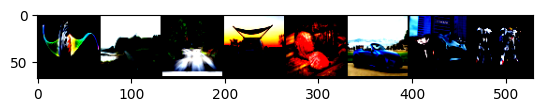

In [10]:
import torchvision
def imshow(img):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (input_img, out_img) in enumerate(train_loader, 0):
    imshow(torchvision.utils.make_grid(input_img[:8]))
    break

## Model

### No skip-connection

In [11]:
#  Tạo feature map ban đầu từ input
class FirstFeature(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FirstFeature, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)

# Khối convolution cơ bản để trích xuất đặc trưng
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


# Để giảm size của feature map và trích xuất các high-level feature.
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            # kernel size = 2, stride = 2 --> giảm 1 nửa
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# Để tăng kích thước feature map và kết hợp với feature map tương ứng từ Encoder(skip connection).
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        self.conv = nn.Sequential(

            # chỉnh ở đây
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels, out_channels*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels*2),
            nn.LeakyReLU(),
        )

        # chỉnh ở đây
        self.conv_block = ConvBlock(out_channels*2, out_channels)

    def forward(self, x):
        x = self.conv(x)
        # chỉnh ở đây
        # x = torch.concat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

# Tạo ra đầu ra cuối cùng từ feature map cuối cùng.
class FinalOutput(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(FinalOutput, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv(x)


class Unet(nn.Module):
    def __init__(
            self, n_channels=3, n_classes=3, features=[64, 128, 256, 512], tgt_size = 256
    ):
        super(Unet, self).__init__()

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.up_size = transforms.Resize((tgt_size, tgt_size), antialias=True)

        self.in_conv1 = FirstFeature(n_channels, 64)
        self.in_conv2 = ConvBlock(64, 64)

        self.enc_1 = Encoder(64, 128)
        self.enc_2 = Encoder(128, 256)
        self.enc_3 = Encoder(256, 512)
        self.enc_4 = Encoder(512, 1024)

        self.dec_1 = Decoder(1024, 512)
        self.dec_2 = Decoder(512, 256)
        self.dec_3 = Decoder(256, 128)
        self.dec_4 = Decoder(128, 64)

        self.out_conv = FinalOutput(64, n_classes)

    def forward(self, x):
        x = self.up_size(x)
        x = self.in_conv1(x)
        x = self.in_conv2(x)

        x1 = self.enc_1(x)
        x2 = self.enc_2(x1)
        x3 = self.enc_3(x2)
        x4 = self.enc_4(x3)
        
        x5 = self.dec_1(x4)
        x6 = self.dec_2(x5)
        x7 = self.dec_3(x6)
        x8 = self.dec_4(x7)

        output = self.out_conv(x8)
        return output

In [12]:
unet_model = Unet(tgt_size=224)
img = torch.ones(2, 3, 64, 64)
unet_model(img).shape

torch.Size([2, 3, 224, 224])

In [13]:
model = Unet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [14]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| loss {:8.3f}".format(
                    epoch, idx, len(train_dataloader), loss.item()
                )
            )
            start_time = time.time()

    epoch_loss = sum(losses) / len(losses)
    return epoch_loss

def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

    epoch_loss = sum(losses) / len(losses)
    return epoch_loss

def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_losses = []
    eval_losses = []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        # Training
        train_loss = train_epoch(
            model, optimizer, criterion, train_dataloader, device, epoch)
        train_losses.append(train_loss)

        # Evaluation
        eval_loss = evaluate_epoch(
            model, criterion, valid_dataloader, device)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss end of epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Loss {:8.3f} "
            "| Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_loss, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(
        save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        'train_loss': train_losses,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [15]:
num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = 'SR_Unet_NoSkip'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_loader, val_loader, num_epochs, device
)

| epoch   1 |    50/   86 batches | loss    0.564
-----------------------------------------------------------
| End of epoch   1 | Time: 52.12s | Train Loss    0.589 | Valid Loss    0.435 
-----------------------------------------------------------
| epoch   2 |    50/   86 batches | loss    0.404
-----------------------------------------------------------
| End of epoch   2 | Time: 62.08s | Train Loss    0.453 | Valid Loss    0.411 
-----------------------------------------------------------
| epoch   3 |    50/   86 batches | loss    0.490
-----------------------------------------------------------
| End of epoch   3 | Time: 65.74s | Train Loss    0.422 | Valid Loss    0.392 
-----------------------------------------------------------
| epoch   4 |    50/   86 batches | loss    0.245
-----------------------------------------------------------
| End of epoch   4 | Time: 66.14s | Train Loss    0.398 | Valid Loss    0.373 
-----------------------------------------------------------
| ep

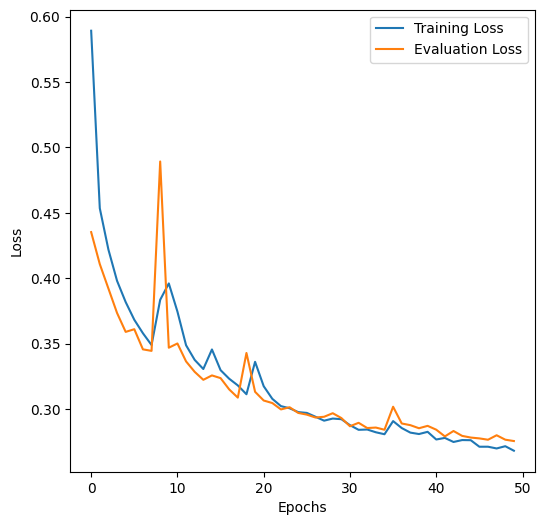

In [16]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(epochs, train_losses, label="Training Loss")
    ax.plot(epochs, eval_losses, label="Evaluation Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend()  
    plt.show()  

plot_result(
    num_epochs,
    metrics["train_loss"],
    metrics["valid_loss"]
)


In [17]:
test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_loss

NameError: name 'test_dataloader' is not defined